# Sparse Dense and Hybrid Search

## Remove old Weaviate DB files

In [ ]:
!rm -rf ~/.local/share/weaviate

## Recreate the example
With the same data as in the previous lesson

In [ ]:
import requests
import json

# Download the data
resp = requests.get('https://raw.githubusercontent.com/weaviate-tutorials/quickstart/main/data/jeopardy_tiny.json')
data = json.loads(resp.text)  # Load data

# Parse the JSON and preview it
print(type(data), len(data))

def json_print(data):
    print(json.dumps(data, indent=2))

In [ ]:
import weaviate, os
from weaviate import EmbeddedOptions
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

client = weaviate.Client(
    embedded_options=EmbeddedOptions(),
    additional_headers={
        "X-OpenAI-Api-BaseURL": os.environ['OPENAI_API_BASE'],
        "X-OpenAI-Api-Key": openai.api_key,  # Replace this with your actual key
    }
)
print(f"Client created? {client.is_ready()}")

In [ ]:
# Uncomment the following two lines if you want to run this block for a second time.
if client.schema.exists("Question"):
   client.schema.delete_class("Question")
 
class_obj = {
    "class": "Question",
    "vectorizer": "text2vec-openai",  # Use OpenAI as the vectorizer
    "moduleConfig": {
        "text2vec-openai": {
            "model": "ada",
            "modelVersion": "002",
            "type": "text",
            "baseURL": os.environ["OPENAI_API_BASE"]
        }
    }
}

client.schema.create_class(class_obj)

In [ ]:
with client.batch.configure(batch_size=5) as batch:
    for i, d in enumerate(data):  # Batch import data
        
        print(f"importing question: {i+1}")
        
        properties = {
            "answer": d["Answer"],
            "question": d["Question"],
            "category": d["Category"],
        }
        
        batch.add_data_object(
            data_object=properties,
            class_name="Question"
        )

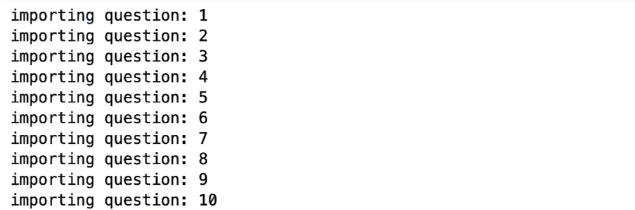

## Queries

### Dense Search/Sementic Search

In [ ]:
response = (
    client.query
    .get("Question", ["question", "answer"])
    .with_near_text({"concepts":["animal"]})
    .with_limit(3)
    .do()
)

json_print(response)

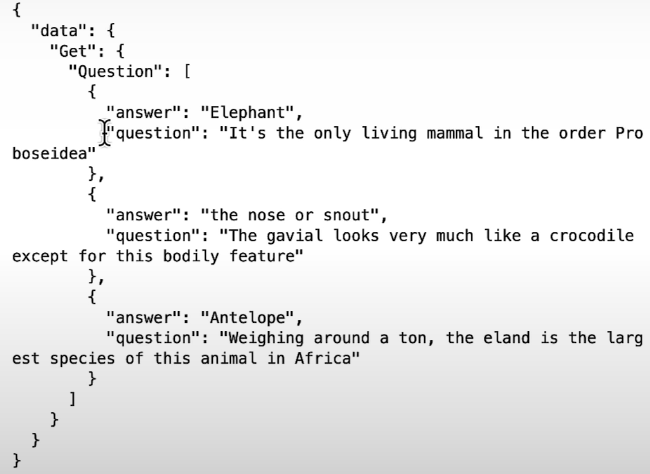

### Sparse Search - BM25 / Key Word Search

In [ ]:
response = (
    client.query
    .get("Question",["question","answer"])
    .with_bm25(query="animal")
    .with_limit(3)
    .do()
)

json_print(response)

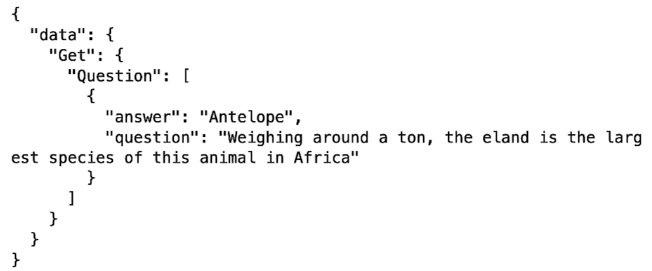

### Hybrid Search

In [ ]:
response = (
    client.query
    .get("Question",["question","answer"])
    .with_hybrid(query="animal", alpha=0.5) # if alpha is 1 then more weighted on sementic search if alpha is 0 then more weighted on keyward search
    .with_limit(3)
    .do()
)

json_print(response)

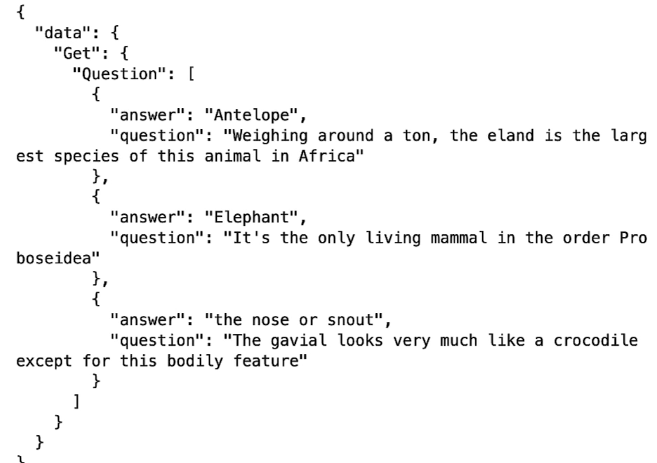

In [ ]:
response = (
    client.query
    .get("Question",["question","answer"])
    .with_hybrid(query="animal", alpha=0)
    .with_limit(3)
    .do()
)

json_print(response)

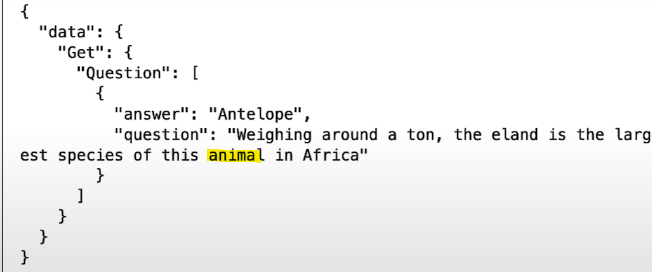

In [ ]:
response = (
    client.query
    .get("Question",["question","answer"])
    .with_hybrid(query="animal", alpha=1)
    .with_limit(3)
    .do()
)

json_print(response)

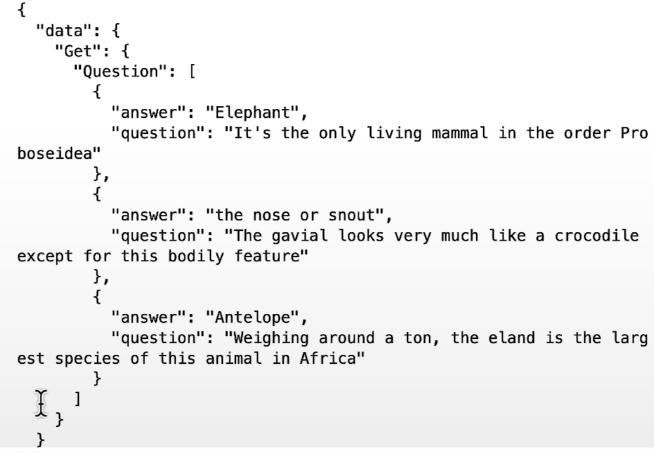